# HSE 2019 ML (bachelors 3rd course)
## Homework #2
### Student: Igor Tukh

### VC-theory

#### 1) (2 points) Identify breakpoints, VC-dimensions and growth functions of following hypotheses:

#### a) $$h(x) = +1\;\textrm{if}\;x_i > a$$
#### b) $$h(x) = +1\;\textrm{if}\;b > x_i > a$$

#### Solution:

$$m_{H}(N) = \max |H(\textbf{x}_{1}, \dots, \textbf{x}_{2})|$$

$$d_{vc}(H) = \max\{N\;|\;m_{H}(N) = 2^{N}\}$$

$$\textrm{breakpoint} = \min\{k\;|\;m_{H}(k) < 2^{k}\} = d_{vc}(H) + 1$$

Here and further $x_k$ is a designation for $x_{k, i}$, where the index i is from the statement and $x_{k, i}$ is a value of the ith feature of kth point.

$\textbf{a)}$

In this case, breakpoint is obviously 2. Let's prove it:

Let's assume $k = 1 \Rightarrow$ there are two cases $h(x_0) = -1$ and $h(x_0) = +1$ and both of them are possible

Let's assume $k = 2$ and we have two points: $x_0 < x_1$ (if $x_0 = x_1, h(x_0) \ne h(x_1)$ cases aren't possible)

In this case $h(x_0) = +1 \Rightarrow h(x_1) = +1$, so $h(x_1) = -1, h(x_0) = +1$ isn't possible case. So breakpoint is 2.

So $d_{vc} = 2 - 1 = 1$ 

$m_{H}(N) = N + 1$. Let's prove.

Let's assume we have $x_0 \leq x_1 \leq \dots \leq x_{N - 1}$. Possible dichotomies should have the following form (and all such forms are possible):

\begin{equation}
    \begin{cases}
        h(x_i) = +1, i \geq k \\
        h(x_i) = -1, \;\textrm{otherwise}\; \\
    \end{cases}
    \;\textrm{for all}\;0 \leq k \leq N
\end{equation}

Amount of such dichotomies is exactly $N + 1$

$\textbf{b)}$

In this case, breakpoint is obviously 3. Let's prove it:

Let's notice that for $k = 1$ and $k = 2 (x_0 < x_1)$ all the dichotomies are possible.

In the case $k = 3$ and $x_0 \leq x_1 \leq x_2$ case $h(x_0) = +1, h(x_1) = -1, h(x_2) = +1$ isn't possible, so $k = 3$ is a breakpoint.

$d_{vc} = 3 - 1 = 2$

Let's assume we have $x_0 \leq x_1 \leq \dots \leq x_{N}$

Lets prove lemma: the dichotomy is possible if and only if there are no three indexes $i < j < k: h(x_{i}) = h(x_{k}) = +1, h(x_j) = -1$ and there are no such index $k: x_{k} = x_{k + 1}$ and $h(x_k) \ne h(x_{k + 1})$

If there are no such indexes, we can chose $a = x_{i} - \varepsilon, b = x_{j} + \varepsilon$, where $x_{i}$ is the lowest point: $x_{k} = +1$ and $x_j$ is the greatest such index and $\varepsilon < \min(x_{i} - x_{i - 1}, x_{j + 1} - x_{j})$ (if $i = 0$ or $j = N - 1$, appropriate value is $10^{-9}$). If there are no such index $k : x_{k} = +1$, $a = b = x_{0} - 1$. Anyway, it is correct dichotomy for such h values.

If such indexes exist, it is an obviously incorrect dichotomy.

Now let's assume that there are no equal $x_i$. How much of dichotomies satisfy the lemma? As we just have understood, $\{i: x_i = +1\}$ is a continuous subrange of $[0; N - 1]$ or doesn't exist. So it is $1 + \sum\limits_{l = 0}^{N - 1} (N - l) = 1 + \frac{N \cdot (N + 1)}{2}$

If some of $x_i$ are equal, amount of the correct dichotomies is obviously less.

So $m_{H}(N) = \frac{N \cdot (N + 1)}{2} + 1$ (and breakpoint calculated above satisfy it).

### Perceptron

#### Dataset: blobs2.csv.
#### 2) (4 points) Implement the pocket perceptron algorithm. Train-test split the dataset (80%/20%). Train the algorithm on train points and find the best performing line on test points. Find the best percept Draw dataset points and the resulting line.

In [487]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import torch.nn as nn
import os
import torch

In [477]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, random_split

In [73]:
np.random.seed(23923)

In [74]:
DATASETS_DIR = 'datasets'

In [206]:
def load_csv_dataset(dataset_name, label_name='label'):
    dataset_path = os.path.join(DATASETS_DIR, dataset_name)
    if label_name is not None:
        dataset = pd.read_csv(dataset_path)
        data_columns = np.array([name for name in dataset.columns if name != label_name])
        return dataset[data_columns], dataset[np.array([label_name])]
    else:
        return pd.read_csv(dataset_path)

In [398]:
def predict(w, x):
    return 1 if np.dot(w, x) > 0 else -1

def pocket_algorithm(points, correct_values, test_points, test_values, iterations_amount, metrics):
    best_metrics = 0
    best_w = 0
    w = np.random.normal(0, 1, points.shape[1])
    for _ in tqdm(range(iterations_amount + 1)):
        predicted_values = np.array([predict(w, point) for point in test_points])
        current_metrics = metrics(test_values, predicted_values.reshape(-1))
        if current_metrics > best_metrics:
            best_metrics = current_metrics
            best_w = w
        predicted_values = np.array([predict(w, point) for point in points])
        incorrect_indexes = np.where(predicted_values != correct_values)[0]
        if incorrect_indexes.shape[0] == 0:
            break
        w += correct_values[incorrect_indexes[0]] * points[incorrect_indexes[0]]
    
    return best_w

Now let's plot the results. Function for visualization will be based on [this](https://stats.stackexchange.com/a/71339) visualization

In [401]:
def build_plot_pocket(X, y, iterations_amount, degree=1, plot_title='Pocket algorithm', metrics=f1_score):
    labels = y['label'].unique()
    labels_map = {labels[0]: -1, labels[1]: 1}
    y = y['label'].apply(lambda label: labels_map[label])
    y = y.to_numpy().reshape(-1)
    poly = PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23923)
    w = pocket_algorithm(X_train, y_train, X_test, y_test, iterations_amount, metrics)
    clf = lambda x: predict(w, x)
    train_score = f1_score(y_train, np.array([clf(x) for x in X_train]))
    test_score = f1_score(y_test, np.array([clf(x) for x in X_test]))
    
    h = .02
    x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    y_min, y_max = X[:, 2].min() - 1, X[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    fig, ax = plt.subplots()
    Z = np.array([clf(poly.transform(np.array([point])).reshape(-1)) for point in np.c_[xx.ravel(), yy.ravel()]])

    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.scatter(X[:, 1].reshape(-1), 
               X[:, 2].reshape(-1), 
               c=y.reshape(-1), cmap=plt.cm.coolwarm,
               s=20, 
               edgecolors='k')
    ax.set_title('{}, train f1 score = {}, test f1 score {}'.format(plot_title, train_score, test_score))
    
    plt.show()

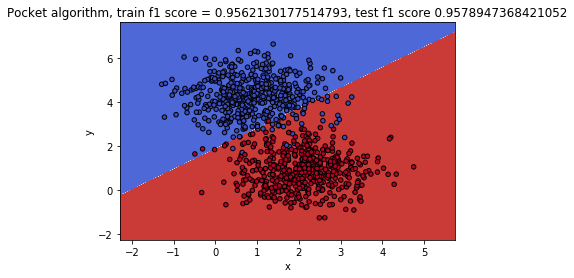

In [402]:
def second_task():
    points, values = load_csv_dataset('blobs2.csv')
    build_plot_pocket(points, values, iterations_amount=100)

second_task()

##### 3) (4 points) Add second-degree polynomial features to the dataset (x_1^2, x_2^2, x_1x_2), find the best perceptron hyperplane. Draw a projection of the hyperplane to the original two-dimensional space. Repeat for third- and fourth-degree polynomial features.

/Users/itukh/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


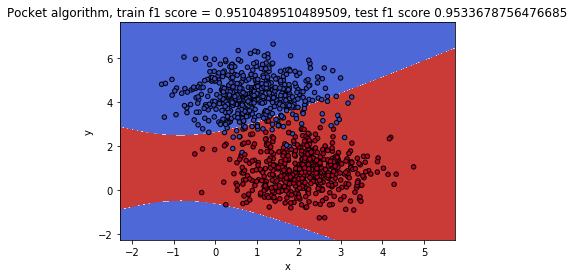

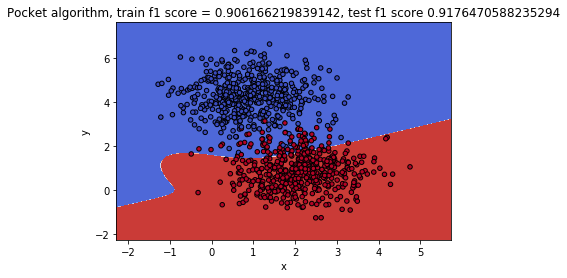

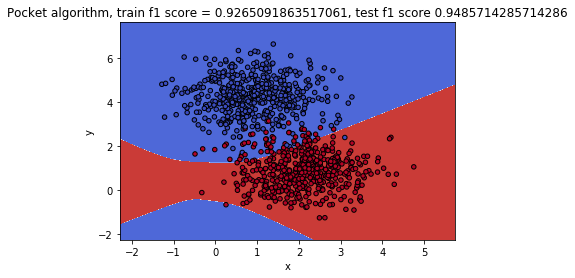

In [403]:
def third_task():
    points, values = load_csv_dataset('blobs2.csv')
    build_plot_pocket(points, values, iterations_amount=100, degree=2)
    build_plot_pocket(points, values, iterations_amount=100, degree=3)
    build_plot_pocket(points, values, iterations_amount=100, degree=4)

third_task()

### Logistic regression

#### Datasets: cancer.csv, spam.csv.

##### 4) (4 points) Implement the logistic regression algorithm. Train it via the stochastic gradient descent and output draw the accuracy/iteration curve.

In [387]:
def get_sigmoid(s):
    if s < 0:
        return 1 - get_sigmoid(-s)
    return 1.0 / (1.0 + np.exp(-s))

def get_prediction(w, x):
    return -1 if get_sigmoid(np.dot(w, x)) < 0.5 else 1

def get_accuracies(w, points, values):
    predicted_values = np.array([get_prediction(w, x) for x in points])
    return np.mean(np.array(predicted_values == values, dtype=int))

def logistic_regression_algorithm(points, values, iterations_amount, batches_amount, eta):
    batch_size = (points.shape[0] + batches_amount - 1) // batches_amount
    w = np.random.normal(0, 1, points.shape[1])
    
    accuracies = [get_accuracies(w, points, values)]
    for _ in tqdm(range(iterations_amount)):
        for batch_ind in range(batches_amount):
            batch_first_ind = batch_size * batch_ind
            batch_last_ind = batch_size * (batch_ind + 1) if batch_ind != batches_amount - 1 else points.shape[0]
            cur_batch_size = batch_last_ind - batch_first_ind
            delta_w = 0
            for point_ind in range(batch_first_ind, batch_last_ind):
                delta_w += (1.0 * values[point_ind] * points[point_ind]) / (
                    1.0 + np.exp(values[point_ind] * np.dot(w, points[point_ind])))
            w += eta * delta_w / cur_batch_size
        accuracies.append(get_accuracies(w, points, values))
    
    return accuracies

In [390]:
def build_plot_logistic_regression(points, values, iterations_amount, batches_amount, dataset_name, eta=0.2):
    PolynomialFeatures(degree=1).fit_transform(points)
    labels = values['label'].unique()
    labels_map = {labels[0]: -1, labels[1]: 1}
    values = values['label'].apply(lambda label: labels_map[label])
    values = values.to_numpy().reshape(-1)
    points = points.to_numpy()
    points = MinMaxScaler().fit_transform(points)
    
    accuracies = logistic_regression_algorithm(points, values, iterations_amount, batches_amount, eta)
    plt.clf()
    plt.title('Accuracy / Iteration number curve for dataset {}'.format(dataset_name))
    plt.xlabel('Iteration number')
    plt.ylabel('Accuracy')
    plt.plot(list(range(len(accuracies))), accuracies)
    plt.show()

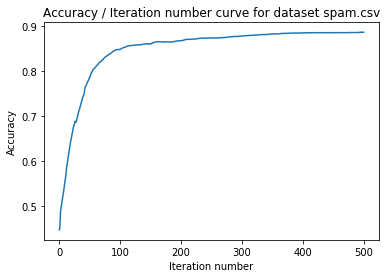

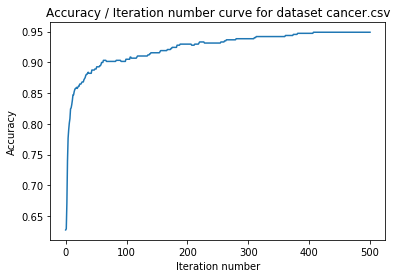

In [391]:
def fourth_task():
    points, values = load_csv_dataset('spam.csv')
    build_plot_logistic_regression(points, values, 500, 25, 'spam.csv')
    points, values = load_csv_dataset('cancer.csv')
    build_plot_logistic_regression(points, values, 500, 25, 'cancer.csv')

fourth_task()

### Neural networks

#### Datasets: mnist.csv, notMNIST.tar.gz

#### 5) (2 points) Prepare the datasets so that every point is represented by a two-dimensional tensor.

We will extend abstract dataset class from `torch`. So we have to implement `__len__` and `__getitem__`

In [503]:
class MNIST(Dataset):
    SHAPE = (28, 28)
    def __init__(self, dataset_name):
        super().__init__()
        self.X, self.y = load_csv_dataset(dataset_name)
        self.X = torch.FloatTensor(self.X.to_numpy().reshape(-1, 1, *self.SHAPE))
        self.y = torch.LongTensor(self.y.to_numpy().reshape(self.X.shape[0]))
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
        
    def __len__(self):
        return self.X.shape[0]

In [606]:
class NOTMNIST(Dataset):
    def __init__(self, dir_path):
        super().__init__()
        self.pathes = []
        self.y = []
        for nested_dir in os.listdir(dir_path):
            for root, dirs, files in os.walk(os.path.join(dir_path, nested_dir)):
                for file in files:
                    try:
                        image = io.imread(os.path.join(root, file))
                    except ValueError:
                        continue
                    self.y.append(nested_dir)
                    self.pathes.append(os.path.join(root, file))
                        
        self.pathes = np.array(self.pathes)
        self.y = np.array(self.y)
        self._map_ys_ints()
    
    def _map_ys_ints(self):
        unique_y = list(np.unique(self.y))
        label_map = {y: ind for ind, y in enumerate(unique_y)}
        self.rev_label_map = {value: key for key, value in label_map.items()}
        map_label = np.vectorize(lambda label: label_map[label])
        self.y = torch.LongTensor(map_label(self.y))
    
    def __getitem__(self, index):
        image = io.imread(self.pathes[index])
        return torch.FloatTensor(image.reshape(1, *image.shape)), self.y[index]
        
    def __len__(self):
        return self.y.shape[0]

In [475]:
def fifth_task():
    dataset_mnist = MNIST('mnist.csv')
    dataset_not_mnist = NOTMNIST(os.path.join(DATASETS_DIR, 'notMNIST_small'))
    
    print('Found {} elements in mnist'.format(len(dataset_mnist)))
    print('Found {} elements in notMNIST'.format(len(dataset_not_mnist)))
    
    return dataset_mnist, dataset_not_mnist

dataset_mnist, dataset_not_mnist = fifth_task()

Found 10000 elements in mnist
Found 18726 elements in notMNIST


#### 6) (4 points) Create a neural network that consists out of three convolutional layers with 8 3x3 filters each and two fully-connected layers with 64 neurons each. Train the network on the mnist dataset with three different types of activation functions (sigmoid, tanh, ReLU). 

In [573]:
torch.manual_seed(239239)
np.random.seed(23923)

In [574]:
class Network(nn.Module):
    def __init__(self, activation_functions):
        super(Network, self).__init__()
        self.activation_functions = activation_functions
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.conv3 = nn.Conv2d(8, 8, 3)
        self.fc1 = nn.Linear(22 ** 2 * 8, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.activation_functions[0](self.conv1(x))
        x = self.activation_functions[1](self.conv2(x))
        x = self.activation_functions[2](self.conv3(x))
        x = x.view(-1, 22 ** 2 * 8)
        x = self.activation_functions[3](self.fc1(x))
        x = self.activation_functions[4](self.fc2(x))
        x = self.fc3(x)
        return x

Let's split the data (80/20)

In [588]:
def get_correct(res_y, y):
    predicted = torch.max(res_y.data, 1)[1]
    return(predicted == y).sum().item()

def train_network(dataset, epochs_amount, activation_functions, loss_function, 
                  train_ratio=0.8, batch_size=25, lr=0.03, momentum=0.9):
    model = Network(activation_functions)
    dataset_size = len(dataset)
    train_size = int(train_ratio * len(dataset))
    test_size = dataset_size - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    result_builder = lambda results: np.array([max_result(r) for r in results])
    
    best_test_accuracy = 0
    
    for ind in range(epochs_amount):
        loss_result = 0
        test_accuracy = 0
        train_accuracy = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            res_y = model(x)
            loss = loss_function(res_y, y)
            loss.backward()
            optimizer.step()
            loss_result += loss.item()
            train_accuracy += get_correct(res_y, y)
        with torch.no_grad():
            for x, y in test_loader:
                res_y = model(x)
                test_accuracy += get_correct(res_y, y)
        test_accuracy = 1.0 * test_accuracy / len(test_dataset)
        train_accuracy = 1.0 * train_accuracy / len(train_dataset)
        best_test_accuracy = np.max([test_accuracy, best_test_accuracy])
        print('Epoch: {}'.format(ind))
        print('Loss function value: {}, train accuracy: {}, test accuracy: {}'
              .format(loss_result, train_accuracy, test_accuracy))
    
    print('\033[1mBest test accuracy: {}\033[0m'.format(test_accuracy))
    print()
    return model

In [589]:
dataset_mnist = fifth_task()[0]
print()
print('Sigmoid:')
train_network(dataset_mnist, 20, [nn.Sequential(), nn.Sequential(), nn.Sequential(), nn.Sigmoid(), nn.Sigmoid()], 
              nn.CrossEntropyLoss())

Found 10000 elements in mnist
Found 18726 elements in notMNIST

Sigmoid:
Epoch: 0
Loss function value: 667.0703607797623, train accuracy: 0.26175, test accuracy: 0.4025
Epoch: 1
Loss function value: 524.6928899288177, train accuracy: 0.418125, test accuracy: 0.5915
Epoch: 2
Loss function value: 316.1574596166611, train accuracy: 0.658875, test accuracy: 0.699
Epoch: 3
Loss function value: 260.8326871395111, train accuracy: 0.726625, test accuracy: 0.728
Epoch: 4
Loss function value: 238.9912494570017, train accuracy: 0.75475, test accuracy: 0.749
Epoch: 5
Loss function value: 225.7357513010502, train accuracy: 0.764125, test accuracy: 0.756
Epoch: 6
Loss function value: 216.13272574543953, train accuracy: 0.775875, test accuracy: 0.7565
Epoch: 7
Loss function value: 209.91508668661118, train accuracy: 0.783875, test accuracy: 0.763
Epoch: 8
Loss function value: 203.9737052321434, train accuracy: 0.788, test accuracy: 0.7635
Epoch: 9
Loss function value: 198.60577069222927, train accura

Network(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3872, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [590]:
print('Tanh:')
train_network(dataset_mnist, 20, [nn.Tanh(), nn.Tanh(), nn.Tanh(), nn.Tanh(), nn.Tanh()], 
              nn.CrossEntropyLoss())

Tanh:
Epoch: 0
Loss function value: 171.36979700624943, train accuracy: 0.8375, test accuracy: 0.8775
Epoch: 1
Loss function value: 106.07950629293919, train accuracy: 0.895125, test accuracy: 0.89
Epoch: 2
Loss function value: 104.53866208717227, train accuracy: 0.895625, test accuracy: 0.927
Epoch: 3
Loss function value: 82.75041891261935, train accuracy: 0.91675, test accuracy: 0.8935
Epoch: 4
Loss function value: 64.51229131408036, train accuracy: 0.93525, test accuracy: 0.923
Epoch: 5
Loss function value: 80.91928074881434, train accuracy: 0.9155, test accuracy: 0.9155
Epoch: 6
Loss function value: 70.23364906385541, train accuracy: 0.92675, test accuracy: 0.9365
Epoch: 7
Loss function value: 61.54072402603924, train accuracy: 0.9355, test accuracy: 0.9335
Epoch: 8
Loss function value: 53.63375421310775, train accuracy: 0.945625, test accuracy: 0.922
Epoch: 9
Loss function value: 93.4688154309988, train accuracy: 0.90725, test accuracy: 0.896
Epoch: 10
Loss function value: 60.8385

Network(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3872, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [591]:
print('ReLU:')
train_network(dataset_mnist, 20, [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
              nn.CrossEntropyLoss())

ReLU:
Epoch: 0
Loss function value: 465.36651299893856, train accuracy: 0.51725, test accuracy: 0.7735
Epoch: 1
Loss function value: 166.4618856459856, train accuracy: 0.843125, test accuracy: 0.8865
Epoch: 2
Loss function value: 126.66081984341145, train accuracy: 0.888375, test accuracy: 0.865
Epoch: 3
Loss function value: 81.84215097595006, train accuracy: 0.921375, test accuracy: 0.8925
Epoch: 4
Loss function value: 64.26491542137228, train accuracy: 0.93925, test accuracy: 0.921
Epoch: 5
Loss function value: 50.611224696971476, train accuracy: 0.953, test accuracy: 0.9275
Epoch: 6
Loss function value: 97.56934164493578, train accuracy: 0.916125, test accuracy: 0.926
Epoch: 7
Loss function value: 54.8854079124867, train accuracy: 0.949375, test accuracy: 0.931
Epoch: 8
Loss function value: 49.401109789847396, train accuracy: 0.95475, test accuracy: 0.92
Epoch: 9
Loss function value: 40.86220810305986, train accuracy: 0.95975, test accuracy: 0.9255
Epoch: 10
Loss function value: 26.

Network(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3872, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

For some unknown reason, double comparing is wrong and for the tanh and ReLU best test accuracies are bigger (0.954 and 0.9355 respectively), but nevermind. And in this case (according to accuracy metric), Tanh is the best one

#### 7) (3 points) Reach an accuracy of 90% on the notMNIST test dataset. All techniques are permitted.

In [611]:
dataset_not_mnist = fifth_task()[1]   
train_network(dataset_not_mnist, 10, [nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.ReLU()], 
              nn.CrossEntropyLoss(), lr=0.01)

Found 10000 elements in mnist
Found 18724 elements in notMNIST
Epoch: 0
Loss function value: 643.853307262063, train accuracy: 0.6706722745176581, test accuracy: 0.8459279038718291
Epoch: 1
Loss function value: 292.8618250414729, train accuracy: 0.8594031644302023, test accuracy: 0.8699599465954606
Epoch: 2
Loss function value: 229.1472031623125, train accuracy: 0.8873756592562921, test accuracy: 0.8883845126835781
Epoch: 3
Loss function value: 198.5488765053451, train accuracy: 0.9035316109219574, test accuracy: 0.8995994659546062
Epoch: 4
Loss function value: 164.20830237073824, train accuracy: 0.9172841978770279, test accuracy: 0.89826435246996
Epoch: 5
Loss function value: 145.08348404802382, train accuracy: 0.9242940116162628, test accuracy: 0.890520694259012
Epoch: 6
Loss function value: 152.6742866242421, train accuracy: 0.9229588089992656, test accuracy: 0.9036048064085447
Epoch: 7
Loss function value: 123.8966625148314, train accuracy: 0.9381801188330329, test accuracy: 0.9097

Network(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3872, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

We reached 0.90 score on the validation part, great!

#### 8) (3 points) Reach an accuracy of 95% on the notMNIST test dataset. All techniques are permitted.

In [651]:
dataset_not_mnist = fifth_task()[1]
train_network(dataset_not_mnist, 15, [nn.Tanh(), nn.ReLU(), nn.Tanh(), nn.ReLU(), nn.Tanh()], 
              nn.CrossEntropyLoss(), lr=0.0025)

Found 10000 elements in mnist
Found 18724 elements in notMNIST
Epoch: 0
Loss function value: 638.7430821880698, train accuracy: 0.67441084184525, test accuracy: 0.8798397863818425
Epoch: 1
Loss function value: 222.5414169691503, train accuracy: 0.8940516723412778, test accuracy: 0.9052069425901201
Epoch: 2
Loss function value: 171.9433751925826, train accuracy: 0.9174844782695775, test accuracy: 0.910547396528705
Epoch: 3
Loss function value: 147.25851854961365, train accuracy: 0.9268976567194072, test accuracy: 0.9220293724966622
Epoch: 4
Loss function value: 129.15660145133734, train accuracy: 0.9379130783096334, test accuracy: 0.9244325767690253
Epoch: 5
Loss function value: 110.56100028567016, train accuracy: 0.9439214900861206, test accuracy: 0.9257676902536716
Epoch: 6
Loss function value: 97.02863620687276, train accuracy: 0.9519327057881033, test accuracy: 0.92630173564753
Epoch: 7
Loss function value: 85.0403050868772, train accuracy: 0.9568729554709927, test accuracy: 0.92817

Network(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3872, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

93.2% It is the best result I reached (including experiments with other networl architectures)